### Training an RNN to predict performance of executive RNN

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
rng = np.random.default_rng()
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


In [2]:
import gym
import neurogym as ngym
tasks = ngym.get_collection('yang19')

In [3]:
tasks

['yang19.go-v0',
 'yang19.rtgo-v0',
 'yang19.dlygo-v0',
 'yang19.anti-v0',
 'yang19.rtanti-v0',
 'yang19.dlyanti-v0',
 'yang19.dm1-v0',
 'yang19.dm2-v0',
 'yang19.ctxdm1-v0',
 'yang19.ctxdm2-v0',
 'yang19.multidm-v0',
 'yang19.dlydm1-v0',
 'yang19.dlydm2-v0',
 'yang19.ctxdlydm1-v0',
 'yang19.ctxdlydm2-v0',
 'yang19.multidlydm-v0',
 'yang19.dms-v0',
 'yang19.dnms-v0',
 'yang19.dmc-v0',
 'yang19.dnmc-v0']

In [4]:
# load data
import os
print('cwd: ', os.getcwd())
exp_name = 'correlated_gates'
sig = '_0_-0.3_2000.0_gaus_cut_tc_mul_gates'
config_file = './../files/'+exp_name+ '/config'+ sig+  '.npy'
file1 = './../files/'+exp_name+ '/testing_log'+ sig+  '.npy'
training_file1 = './../files/'+exp_name+ '/training_log' +sig+ '.npy'

config = np.load(config_file, allow_pickle=True).item()
testing_log = log = np.load( file1, allow_pickle=True).item()
training_log = np.load(training_file1, allow_pickle=True).item()


cwd:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis


A sample of neural activities, from only 10 neurons

Text(0.5, 1.0, 'Tau 100ms ')

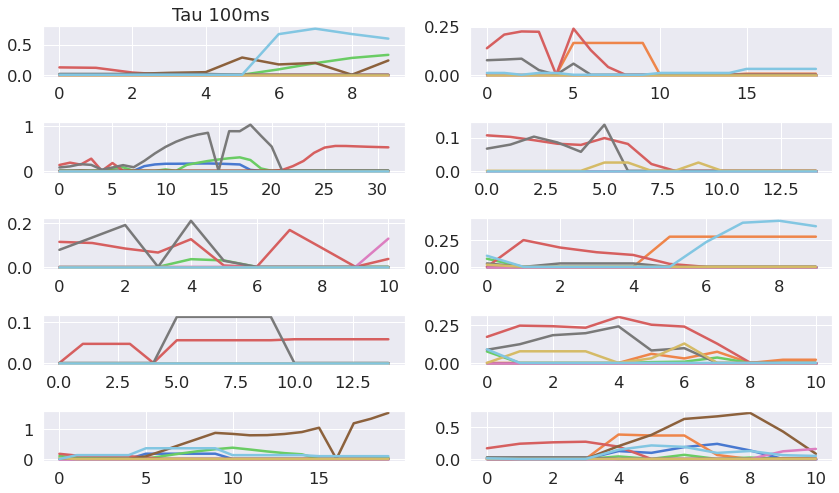

In [5]:
fig, axes = plt.subplots(5, 2, figsize = [12, 7] )

for i in range(10):
    idx = rng.integers(0, len(training_log.sampled_act))
    _=axes.flatten()[i].plot(training_log.sampled_act[idx][:,0,:])
fig.tight_layout()
axes[0,0].set_title('Tau 100ms ')
# plt.savefig('sample_neurons_with_tau_100ms.jpg',dpi=300)

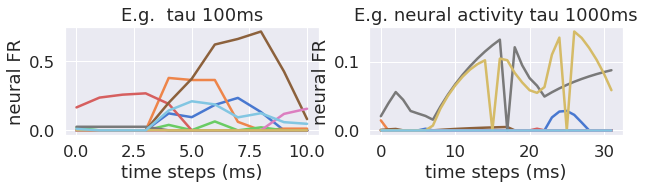

In [6]:
fig, ax =plt.subplots(1,2, figsize=[10,2])
# idx = rng.integers(0, len(training_log.sampled_act))
axes = ax[0]
_=axes.plot(training_log.sampled_act[idx][:,0,:])
axes.set_title('E.g.  tau 100ms') # this is 100ms even that the filename above says 2000ms.
axes.set_ylabel('neural FR')
axes.set_xlabel('time steps (ms)')
# plt.savefig('neural_activity_tau2000.jpg', dpi=300)


axes = ax[1]
training_filetau100 = './../files/'+'tau'+ '/training_log_0_-0.3_1000.0_gaus_cut_tc_mul_gates.npy'
training_log_tau100 = np.load(training_filetau100, allow_pickle=True).item()

_=axes.plot(training_log_tau100.sampled_act[idx+1921][:,2,:])
axes.set_title('E.g. neural activity tau 1000ms')
axes.set_ylabel('neural FR')
axes.set_xlabel('time steps (ms)')
plt.savefig('neural_activity_tau100_2000.jpg', dpi=300)



In [7]:
inputs = (training_log.inputs)
acts = np.stack(training_log.rnn_activity)  # (3127, 100, 356)
outputs = np.stack(training_log.outputs)
labels = np.stack(training_log.labels)
accuracies = np.stack(training_log.accuracies)
task_ids = np.stack(training_log.task_ids)
gradients = np.stack(training_log.gradients)

rl = np.argmax(labels, axis=-1)
ro = np.argmax(outputs, axis=-1)
mses= ((labels-outputs)**2).mean(-1) # shape (7800, 100)
acc = (rl==ro).astype(np.float32)
# print('gradients shape: ', gradients.shape)
print('activations ape: ', acts.shape)
print('outputs  shape : ', outputs.shape)
print('labels   shape : ', labels.shape)
print('task_ids shape : ', task_ids.shape)
print('inputs 0 shape : ', inputs[0].shape)
print('inputs 1 shape : ', inputs[1111].shape)
print('acc shape: ', acc.shape)


activations ape:  (6997, 100, 356)
outputs  shape :  (6997, 100, 17)
labels   shape :  (6997, 100, 17)
task_ids shape :  (6997,)
inputs 0 shape :  (15, 100, 33)
inputs 1 shape :  (32, 100, 33)
acc shape:  (6997, 100)


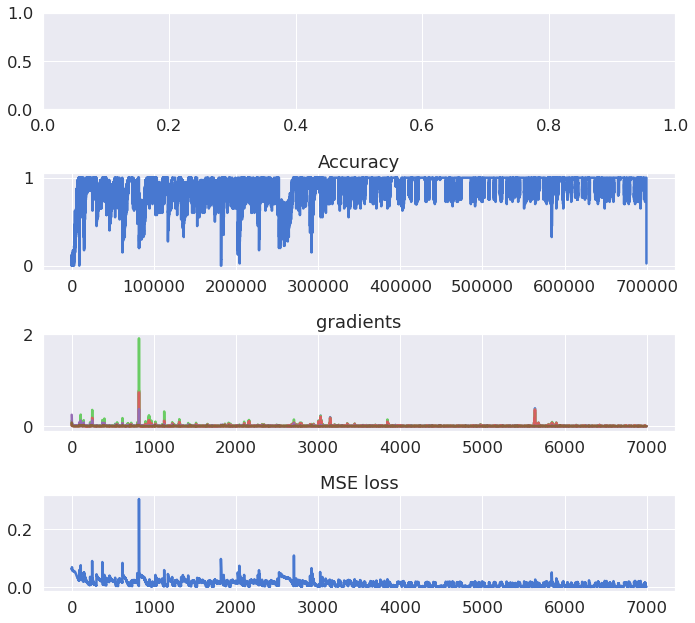

In [8]:

fig, axes = plt.subplots(4,1, figsize=[10,9])
# axes[0].scatter(range(61000), acc.reshape([-1])[:61000]) #.mean(1))
# axes[0].plot(np.convolve( np.ones(40)/40, acc.reshape([-1])[:61000])) #.mean(1))
axes[1].plot(np.convolve( np.ones(40)/40, acc.reshape([-1]))) #.mean(1))
axes[1].set_title('Accuracy')
axes[2].plot(gradients[:])
axes[2].set_title('gradients')
axes[3].plot(mses.mean(1))
axes[3].set_title('MSE loss')
plt.tight_layout()

In [9]:
previous_mse = np.concatenate([mses[:1], mses ])[:-1] #shift by one place to make it run one step behind. 
previous_acc = np.concatenate([acc[:1], acc ])[:-1] #shift by one place to make it run one step behind. 
print('previous acc shape: ', previous_acc.shape)

expanded_previous_acc = np.repeat(previous_acc[..., np.newaxis], 10, axis=-1)   #Expanded merely to emphasize their signal over the numerous acts
print('previous Expanded acc shape: ', expanded_previous_acc.shape)
gathered_inputs = np.concatenate([acts, labels, expanded_previous_acc], axis=-1) #shape  7100 100 266
print('Gathered inputs shape: ', gathered_inputs.shape)

task_ids_oh= F.one_hot(torch.from_numpy(task_ids), 15)
print('task_ids one hot encoded shape: ', task_ids_oh.shape)




previous acc shape:  (6997, 100)
previous Expanded acc shape:  (6997, 100, 10)
Gathered inputs shape:  (6997, 100, 383)
task_ids one hot encoded shape:  torch.Size([6997, 15])


In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # self.bn = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        # inp = self.bn(inp)
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

In [11]:
def test_model(model,test_trials_idx, test_input_length= 60, ):
# use_inputs = gathered_inputs[testing]
# use_outputs= task_ids_oh.reshape([task_ids_oh.shape[0], 1, task_ids_oh.shape[1]]).repeat([1,use_inputs.shape[1], 1])
# use_outputs= task_ids_repeated[testing]

    model.eval()
    model_acts= []
    model_preds= []
    b_example = rng.choice(test_trials_idx)
    # if (b_example + test_input_length) > np.max(test_trials_idx): b_example -= (b_example + test_input_length) - np.max(test_trials_idx)
    # print('b_example: ', b_example)
    with torch.no_grad():
        # for b in trange (use_inputs.shape[0]//test_input_length):
        eins= torch.tensor(gathered_inputs[b_example:b_example+test_input_length])
        gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        #     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        model_acts =gacts.detach().cpu().numpy()
        model_preds= gpreds.detach().cpu().numpy()
        # print('gru_preds shape : ', model_preds.shape)
        # print('taskIDs : ', task_ids[b_example:b_example+test_input_length])

        gt = task_ids[b_example:b_example+test_input_length]
        preds = np.argmax(model_preds, axis=-1)
        # preds # [60, 100] for the whole seq, and 100 batchs. not each seq step of 60 compared to its
        acc = 0
        for s in range(test_input_length):
            acc += (preds[s]== gt[s]).sum()/ len(preds[s])
        acc = acc/test_input_length 
        # print('accuracy: ', acc)
        # acc = accuracy_measure(input= gpreds.squeeze().permute([0,2,1]), target=torch.Tensor(task_ids_repeated[b_example:b_example+test_input_length],))

    model.train()
    model_preds = np.stack(model_preds)
    model_acts = np.stack(model_acts)
    return (model_preds, model_acts, acc)


In [12]:
task_ids_repeated = task_ids[..., np.newaxis].repeat(100,1)
print('dims after adding batch dim: ', task_ids_repeated.shape)

dims after adding batch dim:  (6997, 100)


In [13]:
#hold out set
# training = list(range(2300)) + list(range(2500, 2887))
# testing = list(range(2300, 2500))
training = list(range(6000)) + list(range(6700, 6997))
testing = list(range(6000, 6700))

2.650:   0%|          | 0/2000 [00:00<?, ?it/s]

b_example:  6428


2.650:   0%|          | 1/2000 [00:00<19:40,  1.69it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4
  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0
  0  0  0  0  0  0  0  0  0  9  9  9]
accuracy:  0.0


2.432:   0%|          | 10/2000 [00:02<07:21,  4.51it/s]

b_example:  6621


2.432:   1%|          | 11/2000 [00:03<09:52,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10 10 10
 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8  8 11 11 11 11 11 11 11
 11 11 11 11 11 14 14 14 14 14 14 14]
accuracy:  0.0


2.637:   1%|          | 20/2000 [00:05<07:40,  4.30it/s]

b_example:  6655


2.637:   1%|          | 21/2000 [00:05<09:59,  3.30it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14
 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  5  5  5  5]
accuracy:  0.024166666666666663


2.326:   2%|▏         | 30/2000 [00:07<07:36,  4.31it/s]

b_example:  6567


2.326:   2%|▏         | 31/2000 [00:08<09:58,  3.29it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10
 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11
 11  5  5  5  5  5  5  5  5  5  5  5]
accuracy:  0.0


2.698:   2%|▏         | 40/2000 [00:11<10:49,  3.02it/s]

b_example:  6396


2.698:   2%|▏         | 41/2000 [00:11<15:33,  2.10it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7
  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10
 10 10 10 10 10 10  4  4  4  4  4  4]
accuracy:  0.0


2.874:   2%|▎         | 50/2000 [00:14<08:20,  3.89it/s]

b_example:  6424


2.874:   3%|▎         | 51/2000 [00:14<10:25,  3.12it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10
 10 10  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6
  6  0  0  0  0  0  0  0  0  0  0  0]
accuracy:  0.19666666666666668


3.575:   3%|▎         | 60/2000 [00:16<07:13,  4.48it/s]

b_example:  6312


3.575:   3%|▎         | 61/2000 [00:17<09:31,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1
  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11
 11 11 11 11 11 11 11 11  3  3  3  3]
accuracy:  0.13333333333333333


2.758:   4%|▎         | 70/2000 [00:19<07:37,  4.22it/s]

b_example:  6048


2.758:   4%|▎         | 71/2000 [00:20<10:22,  3.10it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0
  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10
 10 10 10 10 10 10 10  1  1  1  1  1]
accuracy:  0.232


2.711:   4%|▍         | 80/2000 [00:22<07:42,  4.15it/s]

b_example:  6054


2.711:   4%|▍         | 81/2000 [00:22<09:56,  3.22it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0
  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10
 10  1  1  1  1  1  1  1  1  1  1  1]
accuracy:  0.13883333333333336


2.207:   4%|▍         | 90/2000 [00:25<10:59,  2.90it/s]

b_example:  6360


2.207:   5%|▍         | 91/2000 [00:26<16:12,  1.96it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8
  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9
  9  9  9  9  9  9  9  7  7  7  7  7]
accuracy:  0.21583333333333327


2.201:   5%|▌         | 100/2000 [00:30<12:33,  2.52it/s]

b_example:  6574


2.201:   5%|▌         | 101/2000 [00:30<13:14,  2.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7
  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6]
accuracy:  0.027


2.474:   6%|▌         | 110/2000 [00:32<07:10,  4.39it/s]

b_example:  6123


2.474:   6%|▌         | 111/2000 [00:33<09:24,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  3  3  3  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14
 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0  0
  0  0  0  0  0  0  2  2  2  2  2  2]
accuracy:  0.129


2.543:   6%|▌         | 120/2000 [00:35<07:04,  4.43it/s]

b_example:  6296


2.543:   6%|▌         | 121/2000 [00:35<09:13,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6
  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1
  0  0  0  0  0  0  0  0  0  0  0  0]
accuracy:  0.37833333333333324


2.563:   6%|▋         | 130/2000 [00:37<06:47,  4.59it/s]

b_example:  6190


2.563:   7%|▋         | 131/2000 [00:37<09:05,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11  4
  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12
  7  7  7  7  7  7  7  7  7  8  8  8]
accuracy:  0.15333333333333335


1.708:   7%|▋         | 140/2000 [00:42<14:30,  2.14it/s]

b_example:  6114


1.708:   7%|▋         | 141/2000 [00:42<17:50,  1.74it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3  3  3  3  3  3
  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9
  9  9  9  0  0  0  0  0  0  0  0  0]
accuracy:  0.1513333333333333


2.338:   8%|▊         | 150/2000 [00:46<12:58,  2.38it/s]

b_example:  6351


2.338:   8%|▊         | 151/2000 [00:47<16:39,  1.85it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3
  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13
 13 13 13  9  9  9  9  9  9  9  9  9]
accuracy:  0.21133333333333332


1.794:   8%|▊         | 160/2000 [00:51<12:41,  2.42it/s]

b_example:  6304


1.794:   8%|▊         | 161/2000 [00:52<19:45,  1.55it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5
  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0 11 11 11 11 11 11 11 11]
accuracy:  0.4108333333333335


2.192:   8%|▊         | 170/2000 [00:56<13:01,  2.34it/s]

b_example:  6040


2.192:   9%|▊         | 171/2000 [00:56<16:51,  1.81it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  5  5  5  5  5  5  5  5  5  5  5  5  2  2  2  2  2  2  2  2  2
  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4
  4  4 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.013166666666666669


2.337:   9%|▉         | 180/2000 [00:59<08:01,  3.78it/s]

b_example:  6284


2.337:   9%|▉         | 181/2000 [01:00<11:25,  2.65it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4
  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5
  1  1  1  1  1  1  1  1  1  1  1  1]
accuracy:  0.46116666666666667


1.484:  10%|▉         | 190/2000 [01:02<06:45,  4.47it/s]

b_example:  6223


1.484:  10%|▉         | 191/2000 [01:02<08:52,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13
 13  2  2  2  2  2  2  2  2  2  2  2]
accuracy:  0.40266666666666656


2.227:  10%|█         | 200/2000 [01:05<06:33,  4.57it/s]

b_example:  6394


2.227:  10%|█         | 201/2000 [01:05<08:46,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7
  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10
 10 10 10 10 10 10 10 10  4  4  4  4]
accuracy:  0.13149999999999998


1.249:  10%|█         | 210/2000 [01:07<06:26,  4.63it/s]

b_example:  6375


1.249:  11%|█         | 211/2000 [01:07<08:36,  3.46it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13
 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7  7  7  7
  7  7 12 12 12 12 12 12 12 12 12 12]
accuracy:  0.30816666666666664


2.466:  11%|█         | 220/2000 [01:10<06:44,  4.40it/s]

b_example:  6662


2.466:  11%|█         | 221/2000 [01:10<08:46,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14
 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2
  2  5  5  5  5  5  5  5  5  5  5  5]
accuracy:  0.6628333333333332


1.096:  12%|█▏        | 230/2000 [01:12<07:42,  3.82it/s]

b_example:  6145


1.096:  12%|█▏        | 231/2000 [01:13<10:23,  2.84it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0
  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6
  6  6  6  6  6  6  6  6 11 11 11 11]
accuracy:  0.5269999999999999


2.824:  12%|█▏        | 240/2000 [01:17<11:57,  2.45it/s]

b_example:  6310


2.824:  12%|█▏        | 241/2000 [01:17<16:09,  1.82it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1
  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11
 11 11 11 11 11 11 11 11 11 11  3  3]
accuracy:  0.36266666666666664


0.927:  12%|█▎        | 250/2000 [01:20<06:49,  4.27it/s]

b_example:  6142


0.927:  13%|█▎        | 251/2000 [01:20<08:53,  3.28it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0
  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6
  6  6  6  6  6  6  6  6  6  6  6 11]
accuracy:  0.5705000000000001


1.766:  13%|█▎        | 260/2000 [01:22<06:27,  4.49it/s]

b_example:  6396


1.766:  13%|█▎        | 261/2000 [01:22<09:15,  3.13it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7
  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10
 10 10 10 10 10 10  4  4  4  4  4  4]
accuracy:  0.35483333333333333


0.961:  14%|█▎        | 270/2000 [01:25<07:07,  4.05it/s]

b_example:  6365


0.961:  14%|█▎        | 271/2000 [01:25<09:07,  3.16it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8
  8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9
  9  9  7  7  7  7  7  7  7  7  7  7]
accuracy:  0.4454999999999999


2.554:  14%|█▍        | 280/2000 [01:27<06:22,  4.50it/s]

b_example:  6265


2.554:  14%|█▍        | 281/2000 [01:28<08:28,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14
 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6
  6  6  6  6  6  6  6  5  5  5  5  5]
accuracy:  0.26433333333333325


0.991:  14%|█▍        | 290/2000 [01:30<06:16,  4.54it/s]

b_example:  6459


0.991:  15%|█▍        | 291/2000 [01:30<08:27,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0
  0  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13
 13 13 13 13  8  8  8  8  8  8  8  8]
accuracy:  0.5738333333333334


0.990:  15%|█▌        | 300/2000 [01:34<10:45,  2.63it/s]

b_example:  6216


0.990:  15%|█▌        | 301/2000 [01:34<14:07,  2.00it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13
 13 13 13 13 13 13 13 13  2  2  2  2]
accuracy:  0.42100000000000004


0.874:  16%|█▌        | 310/2000 [01:38<07:38,  3.69it/s]

b_example:  6599


0.874:  16%|█▌        | 311/2000 [01:38<09:12,  3.06it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5  5  5
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10 10 10 10 10
 10 10 10 10 10  8  8  8  8  8  8  8]
accuracy:  0.5099999999999999


0.919:  16%|█▌        | 320/2000 [01:40<06:16,  4.46it/s]

b_example:  6344


0.919:  16%|█▌        | 321/2000 [01:40<08:20,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11
  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13
 13 13 13 13 13 13 13 13 13 13  9  9]
accuracy:  0.7373333333333333


1.045:  16%|█▋        | 330/2000 [01:42<06:13,  4.47it/s]

b_example:  6204


1.045:  17%|█▋        | 331/2000 [01:43<08:15,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12
 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8  8  8  8
  8  8  8  8  8  8  8  8 13 13 13 13]
accuracy:  0.6126666666666668


1.823:  17%|█▋        | 340/2000 [01:45<06:06,  4.53it/s]

b_example:  6435


1.823:  17%|█▋        | 341/2000 [01:45<08:08,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4
  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0
  0  0  9  9  9  9  9  9  9  9  9  9]
accuracy:  0.5433333333333333


1.343:  18%|█▊        | 350/2000 [01:47<06:06,  4.50it/s]

b_example:  6559


1.343:  18%|█▊        | 351/2000 [01:48<08:11,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12 12 12 12 10 10
 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11
 11 11 11 11 11 11 11 11 11  5  5  5]
accuracy:  0.8175


1.157:  18%|█▊        | 360/2000 [01:50<05:58,  4.57it/s]

b_example:  6554


1.157:  18%|█▊        | 361/2000 [01:50<07:58,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12
 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7
  7  7 11 11 11 11 11 11 11 11 11 11]
accuracy:  0.6883333333333331


0.967:  18%|█▊        | 370/2000 [01:52<05:55,  4.58it/s]

b_example:  6166


0.967:  19%|█▊        | 371/2000 [01:53<07:54,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6
  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11  4
  4  4  4  4  4  4  4  4  4  4  4  4]
accuracy:  0.5883333333333333


1.451:  19%|█▉        | 380/2000 [01:55<05:54,  4.57it/s]

b_example:  6572


1.451:  19%|█▉        | 381/2000 [01:55<07:55,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7  7
  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5
  5  5  5  5  5  5  5  5  6  6  6  6]
accuracy:  0.6936666666666668


1.021:  20%|█▉        | 390/2000 [01:57<05:51,  4.58it/s]

b_example:  6339


1.021:  20%|█▉        | 391/2000 [01:57<07:53,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11 11 11 11
 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8
  8  8  8 13 13 13 13 13 13 13 13 13]
accuracy:  0.3523333333333334


1.451:  20%|██        | 400/2000 [02:00<05:43,  4.65it/s]

b_example:  6397


1.451:  20%|██        | 401/2000 [02:00<07:44,  3.44it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7  7
  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10
 10 10 10 10 10  4  4  4  4  4  4  4]
accuracy:  0.6405000000000001


1.009:  20%|██        | 410/2000 [02:02<05:44,  4.62it/s]

b_example:  6186


1.009:  21%|██        | 411/2000 [02:02<07:44,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11
 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12
 12 12 12 12  7  7  7  7  7  7  7  7]
accuracy:  0.1486666666666666


0.448:  21%|██        | 420/2000 [02:05<05:55,  4.44it/s]

b_example:  6121


0.448:  21%|██        | 421/2000 [02:05<07:45,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  3  3  3  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14
 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0
  0  0  0  0  0  0  0  0  2  2  2  2]
accuracy:  0.6138333333333332


1.176:  22%|██▏       | 430/2000 [02:07<05:45,  4.55it/s]

b_example:  6545


1.176:  22%|██▏       | 431/2000 [02:07<07:42,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14
 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10
  7  7  7  7  7  7  7  7  7  7  7 11]
accuracy:  0.5315


1.254:  22%|██▏       | 440/2000 [02:09<05:30,  4.72it/s]

b_example:  6427


1.254:  22%|██▏       | 441/2000 [02:10<07:22,  3.52it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4
  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0
  0  0  0  0  0  0  0  0  0  0  9  9]
accuracy:  0.582


0.982:  22%|██▎       | 450/2000 [02:12<05:26,  4.75it/s]

b_example:  6176


0.982:  23%|██▎       | 451/2000 [02:12<07:16,  3.55it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6
  6 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4
  4  4 12 12 12 12 12 12 12 12 12 12]
accuracy:  0.7166666666666666


1.750:  23%|██▎       | 460/2000 [02:14<05:28,  4.69it/s]

b_example:  6000


1.750:  23%|██▎       | 461/2000 [02:14<07:16,  3.53it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13 12 12 12 12 12 12 12 12 12 12 12 12  6  6  6  6  6
  6  6  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  5  5  5  5  5
  5  5  5  5  5  5  5  2  2  2  2  2]
accuracy:  0.5203333333333334


0.155:  24%|██▎       | 470/2000 [02:16<05:20,  4.77it/s]

b_example:  6297


0.155:  24%|██▎       | 471/2000 [02:17<07:03,  3.61it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  5
  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0 11]
accuracy:  0.621


0.999:  24%|██▍       | 480/2000 [02:19<05:22,  4.71it/s]

b_example:  6559


0.999:  24%|██▍       | 481/2000 [02:19<07:10,  3.53it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12 12 12 12 10 10
 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11
 11 11 11 11 11 11 11 11 11  5  5  5]
accuracy:  0.6068333333333331


0.671:  24%|██▍       | 490/2000 [02:21<05:10,  4.86it/s]

b_example:  6669


0.671:  25%|██▍       | 491/2000 [02:22<09:02,  2.78it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  5  5  5  5  5  5
  5  5  5  5  5  5  4  4  4  4  4  4]
accuracy:  0.8040000000000002


1.038:  25%|██▌       | 500/2000 [02:24<05:20,  4.67it/s]

b_example:  6106


1.038:  25%|██▌       | 501/2000 [02:24<06:58,  3.58it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3
  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14  9
  9  9  9  9  9  9  9  9  9  9  9  0]
accuracy:  0.7593333333333335


1.077:  26%|██▌       | 510/2000 [02:26<05:10,  4.80it/s]

b_example:  6178


1.077:  26%|██▌       | 511/2000 [02:26<06:53,  3.60it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11
 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4
 12 12 12 12 12 12 12 12 12 12 12 12]
accuracy:  0.6725000000000001


0.912:  26%|██▌       | 520/2000 [02:29<05:07,  4.81it/s]

b_example:  6304


0.912:  26%|██▌       | 521/2000 [02:29<06:54,  3.57it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5
  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0 11 11 11 11 11 11 11 11]
accuracy:  0.8819999999999997


0.476:  26%|██▋       | 530/2000 [02:31<05:05,  4.81it/s]

b_example:  6258


0.476:  27%|██▋       | 531/2000 [02:31<06:53,  3.56it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8 13 13 13 13 13 13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2  2
  2  2 14 14 14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4
  4  4  6  6  6  6  6  6  6  6  6  6]
accuracy:  0.9375


1.387:  27%|██▋       | 540/2000 [02:33<05:04,  4.79it/s]

b_example:  6278


1.387:  27%|██▋       | 541/2000 [02:33<06:50,  3.56it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2 14 14 14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4
  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5
  5  5  5  5  5  5  1  1  1  1  1  1]
accuracy:  0.7546666666666667


0.334:  28%|██▊       | 550/2000 [02:36<05:03,  4.78it/s]

b_example:  6531


0.334:  28%|██▊       | 551/2000 [02:36<06:48,  3.54it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3
  3  3 14 14 14 14 14 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12 12
 12 12 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.7441666666666668


0.211:  28%|██▊       | 560/2000 [02:38<04:57,  4.84it/s]

b_example:  6105


0.211:  28%|██▊       | 561/2000 [02:38<06:39,  3.61it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3
  3  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14
  9  9  9  9  9  9  9  9  9  9  9  9]
accuracy:  0.7441666666666665


0.807:  28%|██▊       | 570/2000 [02:40<05:09,  4.63it/s]

b_example:  6323


0.807:  29%|██▊       | 571/2000 [02:40<06:46,  3.52it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  0  0  0  0  0  0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3
  3  3  3  3  3  3  3  8  8  8  8  8]
accuracy:  0.7341666666666667


0.094:  29%|██▉       | 580/2000 [02:43<05:00,  4.72it/s]

b_example:  6631


0.094:  29%|██▉       | 581/2000 [02:43<06:40,  3.54it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  6 10 10 10 10 10 10 10 10 10 10 10 10  8  8  8
  8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14
 14 14 14 14 14 14 14 14  1  1  1  1]
accuracy:  0.7953333333333333


0.526:  30%|██▉       | 590/2000 [02:45<04:48,  4.89it/s]

b_example:  6061


0.526:  30%|██▉       | 591/2000 [02:45<06:23,  3.68it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4
  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1  1
  1  1  1  1  1  1  5  5  5  5  5  5]
accuracy:  0.8676666666666667


1.061:  30%|███       | 600/2000 [02:47<04:47,  4.87it/s]

b_example:  6169


1.061:  30%|███       | 601/2000 [02:47<06:26,  3.62it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6
  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4
  4  4  4  4  4  4  4  4  4 12 12 12]
accuracy:  0.8440000000000001


1.053:  30%|███       | 610/2000 [02:50<04:50,  4.79it/s]

b_example:  6571


1.053:  31%|███       | 611/2000 [02:50<06:30,  3.56it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7
  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6]
accuracy:  0.6878333333333332


1.116:  31%|███       | 620/2000 [02:52<04:46,  4.81it/s]

b_example:  6636


1.116:  31%|███       | 621/2000 [02:52<06:17,  3.65it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6 10 10 10 10 10 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8
  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14
 14 14 14  1  1  1  1  1  1  1  1  1]
accuracy:  0.788


0.725:  32%|███▏      | 630/2000 [02:54<04:45,  4.79it/s]

b_example:  6286


0.725:  32%|███▏      | 631/2000 [02:55<06:21,  3.59it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6
  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1
  1  1  1  1  1  1  1  1  1  1  0  0]
accuracy:  0.7508333333333332


0.393:  32%|███▏      | 640/2000 [02:57<04:41,  4.84it/s]

b_example:  6395


0.393:  32%|███▏      | 641/2000 [02:57<06:14,  3.63it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7
  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10
 10 10 10 10 10 10 10  4  4  4  4  4]
accuracy:  0.7693333333333333


0.454:  32%|███▎      | 650/2000 [02:59<04:42,  4.79it/s]

b_example:  6190


0.454:  33%|███▎      | 651/2000 [02:59<06:19,  3.56it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11  4
  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12
  7  7  7  7  7  7  7  7  7  8  8  8]
accuracy:  0.7308333333333333


0.493:  33%|███▎      | 660/2000 [03:01<04:43,  4.72it/s]

b_example:  6385


0.493:  33%|███▎      | 661/2000 [03:02<06:17,  3.54it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9
  9  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12
 12 12 12 12 12 10 10 10 10 10 10 10]
accuracy:  0.9211666666666668


0.571:  34%|███▎      | 670/2000 [03:04<04:41,  4.73it/s]

b_example:  6002


0.571:  34%|███▎      | 671/2000 [03:04<06:12,  3.56it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 12 12 12 12 12 12 12 12 12 12 12 12  6  6  6  6  6  6  6
  6  6  6  6  6  9  9  9  9  9  9  9  9  9  9  9  9  5  5  5  5  5  5  5
  5  5  5  5  5  2  2  2  2  2  2  2]
accuracy:  0.8218333333333334


0.067:  34%|███▍      | 680/2000 [03:06<04:41,  4.69it/s]

b_example:  6225


0.067:  34%|███▍      | 681/2000 [03:06<06:03,  3.63it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  2
  2  2  2  2  2  2  2  2  2  2  2 14]
accuracy:  0.9206666666666669


0.488:  34%|███▍      | 690/2000 [03:08<04:33,  4.79it/s]

b_example:  6268


0.488:  35%|███▍      | 691/2000 [03:09<06:04,  3.59it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14 14 14 14
 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6
  6  6  6  6  5  5  5  5  5  5  5  5]
accuracy:  0.8385000000000001


0.476:  35%|███▌      | 700/2000 [03:11<04:43,  4.59it/s]

b_example:  6429


0.476:  35%|███▌      | 701/2000 [03:11<06:17,  3.44it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4  4
  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0
  0  0  0  0  0  0  0  0  9  9  9  9]
accuracy:  0.7106666666666666


0.112:  36%|███▌      | 710/2000 [03:13<04:47,  4.48it/s]

b_example:  6330


0.112:  36%|███▌      | 711/2000 [03:14<06:25,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3
  8  8  8  8  8  8  8  8  8  8  8  8]
accuracy:  0.8893333333333334


0.498:  36%|███▌      | 720/2000 [03:16<04:46,  4.47it/s]

b_example:  6183


0.498:  36%|███▌      | 721/2000 [03:16<06:17,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11
 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12
 12 12 12 12 12 12 12  7  7  7  7  7]
accuracy:  0.7028333333333335


0.308:  36%|███▋      | 730/2000 [03:18<04:38,  4.55it/s]

b_example:  6439


0.308:  37%|███▋      | 731/2000 [03:19<06:11,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4  4  4  6  6
  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0  0  0  9  9
  9  9  9  9  9  9  9  9  9  9  9  9]
accuracy:  0.7886666666666667


0.133:  37%|███▋      | 740/2000 [03:21<04:38,  4.52it/s]

b_example:  6056


0.133:  37%|███▋      | 741/2000 [03:21<06:15,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1
  1  1  1  1  1  1  1  1  1  1  1  5]
accuracy:  0.9245000000000001


0.190:  38%|███▊      | 750/2000 [03:24<04:46,  4.37it/s]

b_example:  6396


0.190:  38%|███▊      | 751/2000 [03:24<06:14,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7
  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10
 10 10 10 10 10 10  4  4  4  4  4  4]
accuracy:  0.9083333333333333


0.198:  38%|███▊      | 760/2000 [03:26<04:39,  4.44it/s]

b_example:  6293


0.198:  38%|███▊      | 761/2000 [03:26<06:11,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6
  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0]
accuracy:  0.8175


0.375:  38%|███▊      | 770/2000 [03:29<04:37,  4.43it/s]

b_example:  6521


0.375:  39%|███▊      | 771/2000 [03:29<06:05,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  1  1  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14
 12 12 12 12 12 12 12 12 12 12 12 12]
accuracy:  0.8480000000000002


0.150:  39%|███▉      | 780/2000 [03:31<04:29,  4.53it/s]

b_example:  6505


0.150:  39%|███▉      | 781/2000 [03:31<05:53,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13  8  8  8  8  8  8  8  8  8  8  8  8  2  2  2  2  2  2
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3
  3  3  3  3 14 14 14 14 14 14 14 14]
accuracy:  0.9293333333333333


0.210:  40%|███▉      | 790/2000 [03:34<04:27,  4.52it/s]

b_example:  6595


0.210:  40%|███▉      | 791/2000 [03:34<05:54,  3.41it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10
 10 10 10 10 10 10 10 10 10  8  8  8]
accuracy:  0.7516666666666666


0.255:  40%|████      | 800/2000 [03:36<04:22,  4.58it/s]

b_example:  6157


0.255:  40%|████      | 801/2000 [03:36<05:53,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2
  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11
 11 11 11 11 11 11 11 11  4  4  4  4]
accuracy:  0.9051666666666667


0.430:  40%|████      | 810/2000 [03:39<04:28,  4.44it/s]

b_example:  6116


0.430:  41%|████      | 811/2000 [03:39<05:50,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3  3  3  3  3  3  3  3
 14 14 14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9
  9  0  0  0  0  0  0  0  0  0  0  0]
accuracy:  0.9358333333333334


0.054:  41%|████      | 820/2000 [03:41<04:23,  4.47it/s]

b_example:  6210


0.054:  41%|████      | 821/2000 [03:41<05:50,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12
 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8 13 13 13 13 13 13 13 13 13 13]
accuracy:  0.9011666666666668


0.725:  42%|████▏     | 830/2000 [03:44<04:16,  4.56it/s]

b_example:  6591


0.725:  42%|████▏     | 831/2000 [03:44<05:35,  3.48it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11
 11  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6
  6 10 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.7511666666666666


0.409:  42%|████▏     | 840/2000 [03:46<04:19,  4.47it/s]

b_example:  6215


0.409:  42%|████▏     | 841/2000 [03:46<05:41,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13
 13 13 13 13 13 13 13 13 13  2  2  2]
accuracy:  0.9289999999999999


0.326:  42%|████▎     | 850/2000 [03:49<04:19,  4.43it/s]

b_example:  6306


0.326:  43%|████▎     | 851/2000 [03:49<05:40,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  6  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5
  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
  0  0 11 11 11 11 11 11 11 11 11 11]
accuracy:  0.8075


0.353:  43%|████▎     | 860/2000 [03:51<04:11,  4.53it/s]

b_example:  6295


0.353:  43%|████▎     | 861/2000 [03:51<05:32,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6
  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1
  1  0  0  0  0  0  0  0  0  0  0  0]
accuracy:  0.838


0.401:  44%|████▎     | 870/2000 [03:54<04:11,  4.49it/s]

b_example:  6183


0.401:  44%|████▎     | 871/2000 [03:54<05:33,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11
 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12
 12 12 12 12 12 12 12  7  7  7  7  7]
accuracy:  0.9333333333333335


0.332:  44%|████▍     | 880/2000 [03:56<04:05,  4.56it/s]

b_example:  6645


0.332:  44%|████▍     | 881/2000 [03:56<05:28,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8  8 11 11 11 11 11 11 11
 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  2  2  2]
accuracy:  0.9556666666666666


0.303:  44%|████▍     | 890/2000 [03:59<04:06,  4.51it/s]

b_example:  6221


0.303:  45%|████▍     | 891/2000 [03:59<05:26,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7
  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13
 13 13 13  2  2  2  2  2  2  2  2  2]
accuracy:  0.9061666666666667


0.147:  45%|████▌     | 900/2000 [04:01<04:06,  4.46it/s]

b_example:  6246


0.147:  45%|████▌     | 901/2000 [04:01<05:26,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13
 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14 14 14 14 14 14
 14 14 14  4  4  4  4  4  4  4  4  4]
accuracy:  0.9056666666666666


0.074:  46%|████▌     | 910/2000 [04:04<04:14,  4.28it/s]

b_example:  6102


0.074:  46%|████▌     | 911/2000 [04:04<05:29,  3.31it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10  1  1  1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5
  5  3  3  3  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14
 14 14 14  9  9  9  9  9  9  9  9  9]
accuracy:  0.9693333333333333


0.545:  46%|████▌     | 920/2000 [04:06<04:05,  4.39it/s]

b_example:  6693


0.545:  46%|████▌     | 921/2000 [04:07<05:17,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4
 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7]
accuracy:  0.8964999999999999


0.011:  46%|████▋     | 930/2000 [04:09<04:04,  4.38it/s]

b_example:  6587


0.011:  47%|████▋     | 931/2000 [04:09<05:19,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11
 11 11 11 11 11  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6
  6  6  6  6  6 10 10 10 10 10 10 10]
accuracy:  0.9278333333333333


0.250:  47%|████▋     | 940/2000 [04:11<03:57,  4.46it/s]

b_example:  6468


0.250:  47%|████▋     | 941/2000 [04:12<05:15,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  0  0  0  0  0  0  0  0  0  0  0  0  9  9  9  9  9  9  9
  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8  8  8  8  8
  8  8  8  8  8  8  8  2  2  2  2  2]
accuracy:  0.9466666666666667


0.293:  48%|████▊     | 950/2000 [04:14<03:47,  4.61it/s]

b_example:  6352


0.293:  48%|████▊     | 951/2000 [04:14<05:04,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3
  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13
 13 13  9  9  9  9  9  9  9  9  9  9]
accuracy:  0.9399999999999998


0.207:  48%|████▊     | 960/2000 [04:16<03:55,  4.41it/s]

b_example:  6142


0.207:  48%|████▊     | 961/2000 [04:17<05:06,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0
  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6
  6  6  6  6  6  6  6  6  6  6  6 11]
accuracy:  0.9334999999999999


0.262:  48%|████▊     | 970/2000 [04:19<03:51,  4.45it/s]

b_example:  6456


0.262:  49%|████▊     | 971/2000 [04:19<05:05,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0
  0  0  0  0  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13
 13 13 13 13 13 13 13  8  8  8  8  8]
accuracy:  0.9246666666666667


0.477:  49%|████▉     | 980/2000 [04:22<03:48,  4.46it/s]

b_example:  6426


0.477:  49%|████▉     | 981/2000 [04:22<05:03,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10
  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0
  0  0  0  0  0  0  0  0  0  0  0  9]
accuracy:  0.9261666666666667


0.337:  50%|████▉     | 990/2000 [04:24<04:54,  3.42it/s]

b_example:  6389


0.337:  50%|████▉     | 991/2000 [04:25<05:45,  2.92it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9
  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12
 12 10 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.9166666666666666


0.075:  50%|█████     | 1000/2000 [04:27<03:48,  4.38it/s]

b_example:  6372


0.075:  50%|█████     | 1001/2000 [04:27<05:03,  3.30it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13
 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7
  7  7  7  7  7 12 12 12 12 12 12 12]
accuracy:  0.9321666666666666


0.058:  50%|█████     | 1010/2000 [04:30<03:45,  4.40it/s]

b_example:  6380


0.058:  51%|█████     | 1011/2000 [04:30<04:56,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  9  9
  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12
 12 12 12 12 12 12 12 12 12 12 10 10]
accuracy:  0.9260000000000002


0.033:  51%|█████     | 1020/2000 [04:32<03:42,  4.40it/s]

b_example:  6337


0.033:  51%|█████     | 1021/2000 [04:32<04:53,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11 11
 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8
  8  8  8  8  8 13 13 13 13 13 13 13]
accuracy:  0.9308333333333334


0.224:  52%|█████▏    | 1030/2000 [04:35<03:41,  4.38it/s]

b_example:  6227


0.224:  52%|█████▏    | 1031/2000 [04:35<04:51,  3.32it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  2  2  2
  2  2  2  2  2  2  2  2  2 14 14 14]
accuracy:  0.9505


0.118:  52%|█████▏    | 1040/2000 [04:37<03:33,  4.50it/s]

b_example:  6073


0.118:  52%|█████▏    | 1041/2000 [04:37<04:43,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10
 10 10 10 10 10 10  1  1  1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5
  5  5  5  5  5  5  3  3  3  3  3  3]
accuracy:  0.9500000000000001


0.303:  52%|█████▎    | 1050/2000 [04:40<03:31,  4.49it/s]

b_example:  6313


0.303:  53%|█████▎    | 1051/2000 [04:40<04:42,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1
  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11 11
 11 11 11 11 11 11 11  3  3  3  3  3]
accuracy:  0.9530000000000002


0.203:  53%|█████▎    | 1060/2000 [04:42<03:25,  4.58it/s]

b_example:  6184


0.203:  53%|█████▎    | 1061/2000 [04:42<04:31,  3.46it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11
 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12
 12 12 12 12 12 12  7  7  7  7  7  7]
accuracy:  0.9375


0.210:  54%|█████▎    | 1070/2000 [04:45<03:23,  4.57it/s]

b_example:  6647


0.210:  54%|█████▎    | 1071/2000 [04:45<04:29,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10  8  8  8  8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11
 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  2  2  2]
accuracy:  0.969


0.045:  54%|█████▍    | 1080/2000 [04:47<03:25,  4.48it/s]

b_example:  6162


0.045:  54%|█████▍    | 1081/2000 [04:47<04:28,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2
  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11
 11 11 11  4  4  4  4  4  4  4  4  4]
accuracy:  0.9311666666666667


0.204:  55%|█████▍    | 1090/2000 [04:50<03:24,  4.44it/s]

b_example:  6048


0.204:  55%|█████▍    | 1091/2000 [04:50<04:30,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0
  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10
 10 10 10 10 10 10 10  1  1  1  1  1]
accuracy:  0.9461666666666667


0.098:  55%|█████▌    | 1100/2000 [04:52<03:19,  4.51it/s]

b_example:  6156


0.098:  55%|█████▌    | 1101/2000 [04:52<04:27,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2
  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11
 11 11 11 11 11 11 11 11 11  4  4  4]
accuracy:  0.9261666666666666


0.153:  56%|█████▌    | 1110/2000 [04:55<03:20,  4.45it/s]

b_example:  6494


0.153:  56%|█████▌    | 1111/2000 [04:55<04:29,  3.30it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8  8  8  8  8  8  8
  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1
  1  1  1  1  1  3  3  3  3  3  3  3]
accuracy:  0.9621666666666666


0.161:  56%|█████▌    | 1120/2000 [04:57<03:16,  4.48it/s]

b_example:  6603


0.161:  56%|█████▌    | 1121/2000 [04:58<04:23,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5  5  5  5  5  5  5
  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10 10 10 10 10 10 10 10 10
 10  8  8  8  8  8  8  8  8  8  8 11]
accuracy:  0.9359999999999999


0.026:  56%|█████▋    | 1130/2000 [05:00<03:12,  4.51it/s]

b_example:  6200


0.026:  57%|█████▋    | 1131/2000 [05:00<04:17,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4
  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  8  8  8  8]
accuracy:  0.9283333333333333


0.022:  57%|█████▋    | 1140/2000 [05:02<03:10,  4.52it/s]

b_example:  6201


0.022:  57%|█████▋    | 1141/2000 [05:03<04:13,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4
  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  8 13]
accuracy:  0.9436666666666668


0.329:  57%|█████▊    | 1150/2000 [05:05<03:08,  4.52it/s]

b_example:  6434


0.329:  58%|█████▊    | 1151/2000 [05:05<04:09,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4
  4  4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0
  0  0  0  9  9  9  9  9  9  9  9  9]
accuracy:  0.8678333333333333


0.065:  58%|█████▊    | 1160/2000 [05:07<03:02,  4.60it/s]

b_example:  6640


0.065:  58%|█████▊    | 1161/2000 [05:08<04:03,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8  8 11 11
 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1
  1  1  1  1  1  1  1  1  1  1  1  2]
accuracy:  0.9664999999999999


0.049:  58%|█████▊    | 1170/2000 [05:10<03:06,  4.44it/s]

b_example:  6473


0.049:  59%|█████▊    | 1171/2000 [05:10<04:04,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  0  0  0  0  9  9  9  9  9  9  9  9  9  9  9  9
  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8  8  8  8  8  8  8  8  8  8
  8  8  2  2  2  2  2  2  2  2  2  2]
accuracy:  0.9575


0.149:  59%|█████▉    | 1180/2000 [05:13<03:02,  4.49it/s]

b_example:  6391


0.149:  59%|█████▉    | 1181/2000 [05:13<04:00,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9
  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10
 10 10 10 10 10 10 10 10 10 10 10  4]
accuracy:  0.9380000000000001


0.008:  60%|█████▉    | 1190/2000 [05:15<03:00,  4.50it/s]

b_example:  6655


0.008:  60%|█████▉    | 1191/2000 [05:15<04:02,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14
 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  5  5  5  5]
accuracy:  0.9785


0.138:  60%|██████    | 1200/2000 [05:18<02:57,  4.51it/s]

b_example:  6204


0.138:  60%|██████    | 1201/2000 [05:18<03:52,  3.44it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12
 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8  8  8  8
  8  8  8  8  8  8  8  8 13 13 13 13]
accuracy:  0.9565000000000001


0.165:  60%|██████    | 1210/2000 [05:20<02:56,  4.48it/s]

b_example:  6329


0.165:  61%|██████    | 1211/2000 [05:20<03:56,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3
  3  8  8  8  8  8  8  8  8  8  8  8]
accuracy:  0.9618333333333333


0.112:  61%|██████    | 1220/2000 [05:23<02:54,  4.48it/s]

b_example:  6523


0.112:  61%|██████    | 1221/2000 [05:23<03:50,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1
  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 12 12
 12 12 12 12 12 12 12 12 12 12 10 10]
accuracy:  0.9286666666666666


0.159:  62%|██████▏   | 1230/2000 [05:25<02:52,  4.46it/s]

b_example:  6085


0.159:  62%|██████▏   | 1231/2000 [05:26<03:47,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1  1
  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3
  3  3  3  3  3  3  3 14 14 14 14 14]
accuracy:  0.9673333333333333


0.159:  62%|██████▏   | 1240/2000 [05:28<02:44,  4.62it/s]

b_example:  6440


0.159:  62%|██████▏   | 1241/2000 [05:28<03:39,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4  4  4  6  6  6
  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0  0  0  9  9  9
  9  9  9  9  9  9  9  9  9  9  9 13]
accuracy:  0.9466666666666667


0.021:  62%|██████▎   | 1250/2000 [05:31<02:49,  4.42it/s]

b_example:  6592


0.021:  63%|██████▎   | 1251/2000 [05:31<03:44,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
 10 10 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.9535


0.029:  63%|██████▎   | 1260/2000 [05:33<02:47,  4.42it/s]

b_example:  6025


0.029:  63%|██████▎   | 1261/2000 [05:33<03:39,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4]
accuracy:  0.9476666666666667


0.153:  64%|██████▎   | 1270/2000 [05:36<02:40,  4.56it/s]

b_example:  6080


0.153:  64%|██████▎   | 1271/2000 [05:36<03:33,  3.41it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1
  1  1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3
  3  3  3  3  3  3  3  3  3  3  3  3]
accuracy:  0.9786666666666662


0.204:  64%|██████▍   | 1280/2000 [05:38<02:38,  4.53it/s]

b_example:  6585


0.204:  64%|██████▍   | 1281/2000 [05:38<03:31,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11
 11 11 11 11 11 11 11  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6
  6  6  6  6  6  6  6 10 10 10 10 10]
accuracy:  0.9566666666666666


0.132:  64%|██████▍   | 1290/2000 [05:41<02:36,  4.55it/s]

b_example:  6404


0.132:  65%|██████▍   | 1291/2000 [05:41<03:25,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12
 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4
  4  4  4  4  4  4  4  4  4  6  6  6]
accuracy:  0.9103333333333334


0.081:  65%|██████▌   | 1300/2000 [05:43<02:33,  4.56it/s]

b_example:  6041


0.081:  65%|██████▌   | 1301/2000 [05:43<03:29,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  5  5  5  5  5  5  5  5  5  5  5  5  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4
  4 10 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.9521666666666667


0.106:  66%|██████▌   | 1310/2000 [05:46<02:29,  4.61it/s]

b_example:  6172


0.106:  66%|██████▌   | 1311/2000 [05:46<03:19,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6
  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4
  4  4  4  4  4  4 12 12 12 12 12 12]
accuracy:  0.952


0.150:  66%|██████▌   | 1320/2000 [05:48<02:29,  4.54it/s]

b_example:  6348


0.150:  66%|██████▌   | 1321/2000 [05:48<03:18,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3
  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13
 13 13 13 13 13 13  9  9  9  9  9  9]
accuracy:  0.9603333333333333


0.170:  66%|██████▋   | 1330/2000 [05:51<02:27,  4.56it/s]

b_example:  6358


0.170:  67%|██████▋   | 1331/2000 [05:51<03:15,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8
  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9
  9  9  9  9  9  9  9  9  9  7  7  7]
accuracy:  0.9503333333333333


0.006:  67%|██████▋   | 1340/2000 [05:53<02:24,  4.55it/s]

b_example:  6597


0.006:  67%|██████▋   | 1341/2000 [05:53<03:15,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10 10 10
 10 10 10 10 10 10 10  8  8  8  8  8]
accuracy:  0.9631666666666666


0.356:  68%|██████▊   | 1350/2000 [05:56<02:23,  4.52it/s]

b_example:  6531


0.356:  68%|██████▊   | 1351/2000 [05:56<03:09,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3
  3  3 14 14 14 14 14 14 14 14 14 14 14 14 12 12 12 12 12 12 12 12 12 12
 12 12 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.9175


0.241:  68%|██████▊   | 1360/2000 [05:58<02:20,  4.55it/s]

b_example:  6239


0.241:  68%|██████▊   | 1361/2000 [05:59<03:08,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13
 13 13 13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14
 14 14 14 14 14 14 14 14 14 14  4  4]
accuracy:  0.9766666666666666


0.024:  68%|██████▊   | 1370/2000 [06:01<02:17,  4.58it/s]

b_example:  6258


0.024:  69%|██████▊   | 1371/2000 [06:01<03:02,  3.44it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8 13 13 13 13 13 13 13 13 13 13 13 13  2  2  2  2  2  2  2  2  2  2
  2  2 14 14 14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4
  4  4  6  6  6  6  6  6  6  6  6  6]
accuracy:  0.9656666666666668


0.026:  69%|██████▉   | 1380/2000 [06:03<02:16,  4.55it/s]

b_example:  6511


0.026:  69%|██████▉   | 1381/2000 [06:04<03:00,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3 14 14
 14 14 14 14 14 14 14 14 14 14 12 12]
accuracy:  0.9646666666666666


0.082:  70%|██████▉   | 1390/2000 [06:06<02:17,  4.42it/s]

b_example:  6079


0.082:  70%|██████▉   | 1391/2000 [06:06<03:02,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10
  1  1  1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5
  3  3  3  3  3  3  3  3  3  3  3  3]
accuracy:  0.9751666666666667


0.156:  70%|███████   | 1400/2000 [06:08<02:14,  4.48it/s]

b_example:  6682


0.156:  70%|███████   | 1401/2000 [06:09<03:00,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  2  2  2  5  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4  4  4  4
  4  4  4  3  3  3  3  3  3  3  3  3]
accuracy:  0.9591666666666666


0.230:  70%|███████   | 1410/2000 [06:11<02:14,  4.40it/s]

b_example:  6571


0.230:  71%|███████   | 1411/2000 [06:11<02:56,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7
  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6]
accuracy:  0.9414999999999999


0.177:  71%|███████   | 1420/2000 [06:14<02:09,  4.48it/s]

b_example:  6146


0.177:  71%|███████   | 1421/2000 [06:14<02:52,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0
  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6  6
  6  6  6  6  6  6  6 11 11 11 11 11]
accuracy:  0.9373333333333334


0.088:  72%|███████▏  | 1430/2000 [06:16<02:06,  4.51it/s]

b_example:  6082


0.088:  72%|███████▏  | 1431/2000 [06:16<02:46,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1
  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3
  3  3  3  3  3  3  3  3  3  3 14 14]
accuracy:  0.981


0.080:  72%|███████▏  | 1440/2000 [06:19<02:06,  4.44it/s]

b_example:  6077


0.080:  72%|███████▏  | 1441/2000 [06:19<02:45,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10
 10 10  1  1  1  1  1  1  1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5
  5  5  3  3  3  3  3  3  3  3  3  3]
accuracy:  0.9683333333333333


0.189:  72%|███████▎  | 1450/2000 [06:21<02:03,  4.45it/s]

b_example:  6473


0.189:  73%|███████▎  | 1451/2000 [06:21<02:42,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  0  0  0  0  9  9  9  9  9  9  9  9  9  9  9  9
  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8  8  8  8  8  8  8  8  8  8
  8  8  2  2  2  2  2  2  2  2  2  2]
accuracy:  0.9675


0.253:  73%|███████▎  | 1460/2000 [06:24<01:59,  4.52it/s]

b_example:  6156


0.253:  73%|███████▎  | 1461/2000 [06:24<02:38,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2
  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11
 11 11 11 11 11 11 11 11 11  4  4  4]
accuracy:  0.9436666666666668


0.064:  74%|███████▎  | 1470/2000 [06:26<01:56,  4.54it/s]

b_example:  6246


0.064:  74%|███████▎  | 1471/2000 [06:26<02:32,  3.46it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13
 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14 14 14 14 14 14
 14 14 14  4  4  4  4  4  4  4  4  4]
accuracy:  0.993


0.089:  74%|███████▍  | 1480/2000 [06:29<01:57,  4.42it/s]

b_example:  6403


0.089:  74%|███████▍  | 1481/2000 [06:29<02:32,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7 12 12
 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4
  4  4  4  4  4  4  4  4  4  4  6  6]
accuracy:  0.9463333333333334


0.182:  74%|███████▍  | 1490/2000 [06:31<01:51,  4.59it/s]

b_example:  6519


0.182:  75%|███████▍  | 1491/2000 [06:32<02:28,  3.43it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1
  1  1  1  1  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14
 14 14 12 12 12 12 12 12 12 12 12 12]
accuracy:  0.9783333333333334


0.007:  75%|███████▌  | 1500/2000 [06:34<01:52,  4.44it/s]

b_example:  6286


0.007:  75%|███████▌  | 1501/2000 [06:34<02:27,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6
  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1
  1  1  1  1  1  1  1  1  1  1  0  0]
accuracy:  0.9403333333333334


0.038:  76%|███████▌  | 1510/2000 [06:36<01:49,  4.47it/s]

b_example:  6493


0.038:  76%|███████▌  | 1511/2000 [06:37<02:24,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8  8  8  8  8  8
  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1
  1  1  1  1  1  1  3  3  3  3  3  3]
accuracy:  0.9803333333333335


0.098:  76%|███████▌  | 1520/2000 [06:39<01:46,  4.52it/s]

b_example:  6201


0.098:  76%|███████▌  | 1521/2000 [06:39<02:21,  3.39it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4
  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  8 13]
accuracy:  0.9788333333333334


0.115:  76%|███████▋  | 1530/2000 [06:42<01:45,  4.46it/s]

b_example:  6630


0.115:  77%|███████▋  | 1531/2000 [06:42<02:20,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6  6  6  6  6  6  6  6  6  6 10 10 10 10 10 10 10 10 10 10 10 10  8  8
  8  8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14
 14 14 14 14 14 14 14 14 14  1  1  1]
accuracy:  0.9770000000000001


0.034:  77%|███████▋  | 1540/2000 [06:44<01:44,  4.42it/s]

b_example:  6119


0.034:  77%|███████▋  | 1541/2000 [06:44<02:14,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  5  3  3  3  3  3  3  3  3  3  3  3  3  3 14 14 14
 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0
  0  0  0  0  0  0  0  0  0  0  2  2]
accuracy:  0.9571666666666666


0.144:  78%|███████▊  | 1550/2000 [06:47<01:38,  4.58it/s]

b_example:  6655


0.144:  78%|███████▊  | 1551/2000 [06:47<02:12,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14
 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  5  5  5  5]
accuracy:  0.9933333333333334


0.103:  78%|███████▊  | 1560/2000 [06:49<01:39,  4.41it/s]

b_example:  6126


0.103:  78%|███████▊  | 1561/2000 [06:49<02:10,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  3  3  3  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14
 14 14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0
  0  0  0  2  2  2  2  2  2  2  2  2]
accuracy:  0.9675


0.177:  78%|███████▊  | 1570/2000 [06:52<01:35,  4.49it/s]

b_example:  6411


0.177:  79%|███████▊  | 1571/2000 [06:52<02:05,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12
 12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4
  4  4  6  6  6  6  6  6  6  6  6  6]
accuracy:  0.8001666666666668


0.036:  79%|███████▉  | 1580/2000 [06:54<01:33,  4.48it/s]

b_example:  6370


0.036:  79%|███████▉  | 1581/2000 [06:55<02:04,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13
 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7
  7  7  7  7  7  7  7 12 12 12 12 12]
accuracy:  0.9776666666666667


0.101:  80%|███████▉  | 1590/2000 [06:57<01:28,  4.61it/s]

b_example:  6663


0.101:  80%|███████▉  | 1591/2000 [06:57<01:58,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  5  5  5  5  5  5  5  5  5  5  5  5]
accuracy:  0.8043333333333335


0.122:  80%|████████  | 1600/2000 [06:59<01:29,  4.46it/s]

b_example:  6110


0.122:  80%|████████  | 1601/2000 [07:00<01:58,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3  3
  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9
  9  9  9  9  9  9  9  0  0  0  0  0]
accuracy:  0.9816666666666668


0.019:  80%|████████  | 1610/2000 [07:02<01:39,  3.91it/s]

b_example:  6186


0.019:  81%|████████  | 1611/2000 [07:02<02:03,  3.14it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11
 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12
 12 12 12 12  7  7  7  7  7  7  7  7]
accuracy:  0.9783333333333333


0.018:  81%|████████  | 1620/2000 [07:05<01:25,  4.44it/s]

b_example:  6567


0.018:  81%|████████  | 1621/2000 [07:05<01:53,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10
 10 10  7  7  7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11
 11  5  5  5  5  5  5  5  5  5  5  5]
accuracy:  0.9730000000000001


0.026:  82%|████████▏ | 1630/2000 [07:07<01:21,  4.55it/s]

b_example:  6289


0.026:  82%|████████▏ | 1631/2000 [07:08<01:47,  3.45it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6
  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1
  1  1  1  1  1  1  1  0  0  0  0  0]
accuracy:  0.9616666666666666


0.042:  82%|████████▏ | 1640/2000 [07:10<01:22,  4.39it/s]

b_example:  6392


0.042:  82%|████████▏ | 1641/2000 [07:10<01:46,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7
  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10
 10 10 10 10 10 10 10 10 10 10  4  4]
accuracy:  0.9763333333333333


0.017:  82%|████████▎ | 1650/2000 [07:12<01:18,  4.46it/s]

b_example:  6227


0.017:  83%|████████▎ | 1651/2000 [07:13<01:43,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  2  2  2
  2  2  2  2  2  2  2  2  2 14 14 14]
accuracy:  0.9911666666666668


0.069:  83%|████████▎ | 1660/2000 [07:15<01:17,  4.39it/s]

b_example:  6595


0.069:  83%|████████▎ | 1661/2000 [07:15<01:39,  3.40it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 7  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6 10 10 10
 10 10 10 10 10 10 10 10 10  8  8  8]
accuracy:  0.9655000000000004


0.026:  84%|████████▎ | 1670/2000 [07:18<01:16,  4.30it/s]

b_example:  6459


0.026:  84%|████████▎ | 1671/2000 [07:18<01:59,  2.75it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  6  6  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0
  0  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13
 13 13 13 13  8  8  8  8  8  8  8  8]
accuracy:  0.9436666666666668


0.041:  84%|████████▍ | 1680/2000 [07:21<02:13,  2.41it/s]

b_example:  6664


0.041:  84%|████████▍ | 1681/2000 [07:22<02:24,  2.20it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  5
  5  5  5  5  5  5  5  5  5  5  5  4]
accuracy:  0.9903333333333334


0.064:  84%|████████▍ | 1690/2000 [07:24<01:16,  4.04it/s]

b_example:  6325


0.064:  85%|████████▍ | 1691/2000 [07:25<01:40,  3.06it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3
  3  3  3  3  3  8  8  8  8  8  8  8]
accuracy:  0.9901666666666666


0.061:  85%|████████▌ | 1700/2000 [07:27<01:10,  4.25it/s]

b_example:  6060


0.061:  85%|████████▌ | 1701/2000 [07:27<01:30,  3.30it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4
  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1
  1  1  1  1  1  1  1  5  5  5  5  5]
accuracy:  0.975


0.219:  86%|████████▌ | 1710/2000 [07:30<01:06,  4.34it/s]

b_example:  6051


0.219:  86%|████████▌ | 1711/2000 [07:30<01:27,  3.30it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 5  5  5  5  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0
  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10
 10 10 10 10  1  1  1  1  1  1  1  1]
accuracy:  0.9681666666666666


0.104:  86%|████████▌ | 1720/2000 [07:32<01:02,  4.46it/s]

b_example:  6487


0.104:  86%|████████▌ | 1721/2000 [07:33<01:23,  3.35it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13
  8  8  8  8  8  8  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1]
accuracy:  0.9981666666666665


0.075:  86%|████████▋ | 1730/2000 [07:35<01:00,  4.46it/s]

b_example:  6066


0.075:  87%|████████▋ | 1731/2000 [07:35<01:19,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  4
 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1  1  1  1  1  1  1
  1  5  5  5  5  5  5  5  5  5  5  5]
accuracy:  0.9758333333333333


0.084:  87%|████████▋ | 1740/2000 [07:37<00:58,  4.44it/s]

b_example:  6334


0.084:  87%|████████▋ | 1741/2000 [07:38<01:27,  2.97it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0 11 11
 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8
  8  8  8  8  8  8  8  8 13 13 13 13]
accuracy:  0.9905


0.036:  88%|████████▊ | 1750/2000 [07:40<00:58,  4.27it/s]

b_example:  6672


0.036:  88%|████████▊ | 1751/2000 [07:41<01:34,  2.62it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 14 14 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  5  5  5  5  5  5  5  5  5
  5  5  5  4  4  4  4  4  4  4  4  4]
accuracy:  0.9919999999999999


0.056:  88%|████████▊ | 1760/2000 [07:43<00:53,  4.47it/s]

b_example:  6137


0.056:  88%|████████▊ | 1761/2000 [07:43<01:10,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14  9  9  9  9  9  9  9  9
  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2
  2  2  2  2  6  6  6  6  6  6  6  6]
accuracy:  0.9666666666666666


0.060:  88%|████████▊ | 1770/2000 [07:46<00:51,  4.48it/s]

b_example:  6293


0.060:  89%|████████▊ | 1771/2000 [07:46<01:07,  3.41it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6
  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0]
accuracy:  0.9576666666666667


0.044:  89%|████████▉ | 1780/2000 [07:48<00:53,  4.11it/s]

b_example:  6267


0.044:  89%|████████▉ | 1781/2000 [07:49<01:07,  3.23it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [13 13 13 13 13  2  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14 14 14
 14 14 14 14 14 14  4  4  4  4  4  4  4  4  4  4  4  6  6  6  6  6  6  6
  6  6  6  6  6  5  5  5  5  5  5  5]
accuracy:  0.9530000000000001


0.121:  90%|████████▉ | 1790/2000 [07:51<00:49,  4.21it/s]

b_example:  6182


0.121:  90%|████████▉ | 1791/2000 [07:51<01:04,  3.25it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11
 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4  4  4 12 12 12 12
 12 12 12 12 12 12 12 12  7  7  7  7]
accuracy:  0.9681666666666667


0.048:  90%|█████████ | 1800/2000 [07:54<00:48,  4.12it/s]

b_example:  6488


0.048:  90%|█████████ | 1801/2000 [07:54<01:04,  3.10it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8
  8  8  8  8  8  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  3]
accuracy:  0.9874999999999999


0.075:  90%|█████████ | 1810/2000 [07:56<00:43,  4.40it/s]

b_example:  6488


0.075:  91%|█████████ | 1811/2000 [07:57<00:56,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 9  9  9  9  9  9  9  9  9  9  9 13 13 13 13 13 13 13 13 13 13 13 13  8
  8  8  8  8  8  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  3]
accuracy:  0.9879999999999999


0.012:  91%|█████████ | 1820/2000 [07:59<00:43,  4.15it/s]

b_example:  6677


0.012:  91%|█████████ | 1821/2000 [07:59<00:56,  3.15it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2
  2  2  2  2  2  2  2  2  2  2  5  5  5  5  5  5  5  5  5  5  5  5  4  4
  4  4  4  4  4  4  4  4  3  3  3  3]
accuracy:  0.9786666666666668


0.082:  92%|█████████▏| 1830/2000 [08:02<00:37,  4.48it/s]

b_example:  6220


0.082:  92%|█████████▏| 1831/2000 [08:02<00:50,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7
  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13
 13 13 13 13  2  2  2  2  2  2  2  2]
accuracy:  0.9800000000000001


0.077:  92%|█████████▏| 1840/2000 [08:04<00:35,  4.47it/s]

b_example:  6440


0.077:  92%|█████████▏| 1841/2000 [08:04<00:47,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4  4  4  6  6  6
  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0  0  0  9  9  9
  9  9  9  9  9  9  9  9  9  9  9 13]
accuracy:  0.9664999999999999


0.018:  92%|█████████▎| 1850/2000 [08:07<00:33,  4.43it/s]

b_example:  6578


0.018:  93%|█████████▎| 1851/2000 [08:07<00:45,  3.28it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [12 12 12 10 10 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7
  7  7 11 11 11 11 11 11 11 11 11 11 11 11  5  5  5  5  5  5  5  5  5  5
  5  5  6  6  6  6  6  6  6  6  6  6]
accuracy:  0.9806666666666666


0.092:  93%|█████████▎| 1860/2000 [08:09<00:31,  4.42it/s]

b_example:  6109


0.092:  93%|█████████▎| 1861/2000 [08:10<00:41,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  3  3
  3  3  3  3  3  3  3 14 14 14 14 14 14 14 14 14 14 14 14 14  9  9  9  9
  9  9  9  9  9  9  9  9  0  0  0  0]
accuracy:  0.9876666666666668


0.014:  94%|█████████▎| 1870/2000 [08:12<00:28,  4.51it/s]

b_example:  6332


0.014:  94%|█████████▎| 1871/2000 [08:12<00:37,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
 11 11 11 11 11 11 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  8  8
  8  8  8  8  8  8  8  8  8  8 13 13]
accuracy:  0.9963333333333335


0.013:  94%|█████████▍| 1880/2000 [08:15<00:27,  4.35it/s]

b_example:  6370


0.013:  94%|█████████▍| 1881/2000 [08:15<00:35,  3.31it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13
 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  7  7  7
  7  7  7  7  7  7  7 12 12 12 12 12]
accuracy:  0.9778333333333333


0.052:  94%|█████████▍| 1890/2000 [08:17<00:24,  4.45it/s]

b_example:  6655


0.052:  95%|█████████▍| 1891/2000 [08:17<00:32,  3.33it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14
 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  2  2  5  5  5  5]
accuracy:  0.9911666666666666


0.044:  95%|█████████▌| 1900/2000 [08:20<00:22,  4.46it/s]

b_example:  6652


0.044:  95%|█████████▌| 1901/2000 [08:20<00:29,  3.41it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8  8  8  8 11 11 11 11 11 11 11 11 11 11 11 11 14 14
 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  5]
accuracy:  0.9903333333333334


0.104:  96%|█████████▌| 1910/2000 [08:22<00:19,  4.57it/s]

b_example:  6249


0.104:  96%|█████████▌| 1911/2000 [08:22<00:25,  3.42it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13 13 13  2
  2  2  2  2  2  2  2  2  2  2  2 14 14 14 14 14 14 14 14 14 14 14 14 14
  4  4  4  4  4  4  4  4  4  4  4  6]
accuracy:  0.98


0.024:  96%|█████████▌| 1920/2000 [08:25<00:25,  3.08it/s]

b_example:  6639


0.024:  96%|█████████▌| 1921/2000 [08:26<00:31,  2.48it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 6 10 10 10 10 10 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8  8 11
 11 11 11 11 11 11 11 11 11 11 11 14 14 14 14 14 14 14 14 14 14 14 14 14
  1  1  1  1  1  1  1  1  1  1  1  1]
accuracy:  0.9843333333333333


0.081:  96%|█████████▋| 1930/2000 [08:28<00:20,  3.36it/s]

b_example:  6151


0.081:  97%|█████████▋| 1931/2000 [08:28<00:24,  2.87it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [14 14  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0  0
  0  0  2  2  2  2  2  2  2  2  2  2  2  2  6  6  6  6  6  6  6  6  6  6
  6  6 11 11 11 11 11 11 11 11 11 11]
accuracy:  0.9786666666666667


0.024:  97%|█████████▋| 1940/2000 [08:31<00:13,  4.42it/s]

b_example:  6218


0.024:  97%|█████████▋| 1941/2000 [08:31<00:17,  3.38it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13
 13 13 13 13 13 13  2  2  2  2  2  2]
accuracy:  0.9776666666666667


0.064:  98%|█████████▊| 1950/2000 [08:33<00:11,  4.48it/s]

b_example:  6165


0.064:  98%|█████████▊| 1951/2000 [08:33<00:14,  3.34it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  2
  6  6  6  6  6  6  6  6  6  6  6  6 11 11 11 11 11 11 11 11 11 11 11 11
  4  4  4  4  4  4  4  4  4  4  4  4]
accuracy:  0.9916666666666667


0.021:  98%|█████████▊| 1960/2000 [08:36<00:08,  4.48it/s]

b_example:  6514


0.021:  98%|█████████▊| 1961/2000 [08:36<00:11,  3.37it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8  8  8  8  8  8  8  8  8  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1
  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3 14 14 14 14 14
 14 14 14 14 14 14 14 12 12 12 12 12]
accuracy:  0.9896666666666667


0.028:  98%|█████████▊| 1970/2000 [08:38<00:06,  4.48it/s]

b_example:  6060


0.028:  99%|█████████▊| 1971/2000 [08:39<00:08,  3.44it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  4  4  4  4
  4  4  4  4  4  4 10 10 10 10 10 10 10 10 10 10 10 10 10  1  1  1  1  1
  1  1  1  1  1  1  1  5  5  5  5  5]
accuracy:  0.9688333333333333


0.019:  99%|█████████▉| 1980/2000 [08:41<00:04,  4.10it/s]

b_example:  6389


0.019:  99%|█████████▉| 1981/2000 [08:41<00:06,  3.12it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [ 8 13 13 13 13 13 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9
  9  9  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12
 12 10 10 10 10 10 10 10 10 10 10 10]
accuracy:  0.9791666666666667


0.099: 100%|█████████▉| 1990/2000 [08:44<00:02,  4.50it/s]

b_example:  6695


0.099: 100%|█████████▉| 1991/2000 [08:44<00:02,  3.36it/s]

gru_preds shape :  (60, 100, 15)
taskIDs :  [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4
 4 3 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 7]
accuracy:  0.9733333333333333


0.049: 100%|██████████| 2000/2000 [08:46<00:00,  3.80it/s]


Text(0.5, 0, 'Training batch')

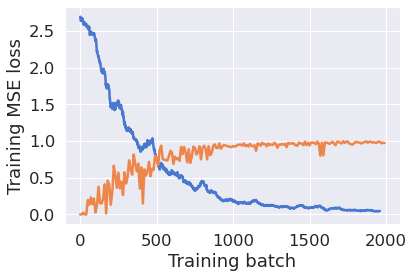

In [14]:
input_length = 20
training_cycles = 2000

rng = np.random.default_rng()

training_inputs = gathered_inputs[training]
# training_outputs= task_ids_oh.reshape([task_ids_oh.shape[0], 1, task_ids_oh.shape[1]]).repeat([1,training_inputs.shape[1], 1])
training_outputs= task_ids_repeated[training]

model = Net(input_size=training_inputs.shape[-1], hidden_size=258, output_size=task_ids_oh.shape[-1])
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
# crit = nn.CrossEntropyLoss(reduction='mean')
crit = F.cross_entropy

losses,accs = [],[]
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = rng.integers(0, training_inputs.shape[0]- input_length)
    # bi=1000 # NOTE One batch only TODO
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(training_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(training_outputs[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(input= pred.squeeze().permute([0,2,1]) , target = outs)
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())

    if train_i % 50== 0: 
        _,_, acc = test_model(model, testing, test_input_length=60)
        accs.append((train_i, acc))
        


sloss = np.stack(losses)
saccs = np.stack(accs)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)
plt.plot(saccs[:,0], saccs[:,1])
ax = plt.gca()
ax.set_ylabel('Training MSE loss')
ax.set_xlabel('Training batch')


Text(0.5, 0, 'Training batch')

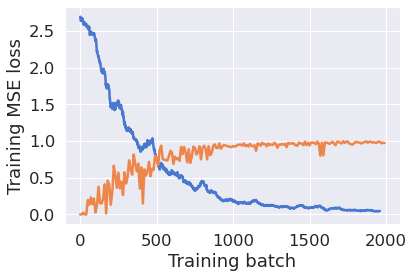

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


gru_acts shape :  (1, 60, 100, 258)
gru_preds shape :  (1, 60, 100, 15)
[ 6 11 11 11 11 11 11 11 11 11 11 11 11  4  4  4  4  4  4  4  4  4  4  4
  4  4 12 12 12 12 12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  8  8  8  8]


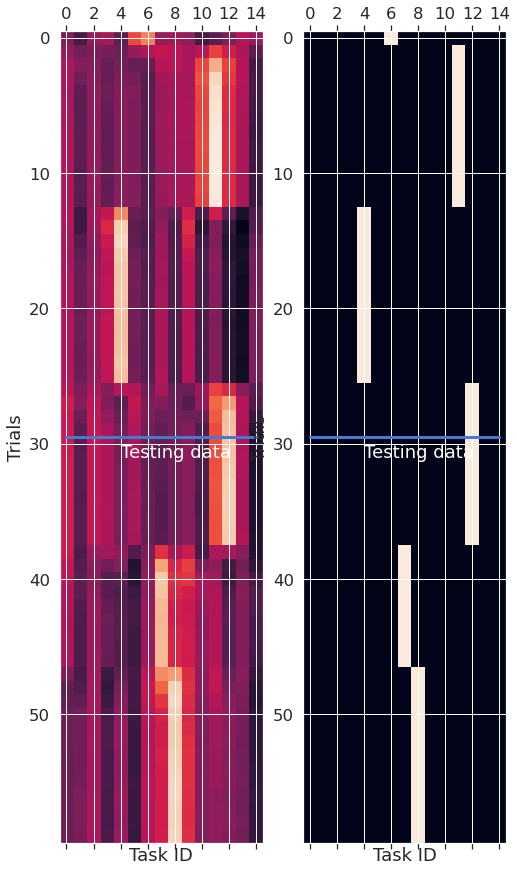

In [76]:
#eval
test_input_length= 60
model.eval()
gru_acts= []
gru_preds= []
b_example = 6200#2270
with torch.no_grad():
    # for b in trange (use_inputs.shape[0]//test_input_length):
    for b in trange (b_example, b_example+1):
        eins= torch.tensor(gathered_inputs[b:b+test_input_length])
        gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
    #     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        gru_acts.append(gacts.detach().cpu().numpy())
        gru_preds.append(gpreds.detach().cpu().numpy())
model.train()

gru_preds = np.stack(gru_preds)
gru_acts = np.stack(gru_acts)
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
fig, axes = plt.subplots(1,2, figsize=[8,16])
ax = axes[0]
ax.matshow(gru_preds.reshape([-1, 100, 15]).mean(1))
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')

ax = axes[1]
ax.matshow(task_ids_oh[b_example:b_example+test_input_length])
ax = plt.gca()
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')


print(task_ids[b_example:b_example+test_input_length])
plt.savefig('Cognitive_observer_preds.jpg', dpi=300)

b_example:  5970
gru_preds shape :  (60, 100, 15)
taskIDs :  [11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8
 13 13 13 13 13 13 13 13 13 13 13 13 13 12 12 12 12 12 12 12 12 12 12 12
 12  6  6  6  6  6  6  6  6  6  6  6]
accuracy:  0.9928333333333333
gru_acts shape :  (60, 100, 258)


Text(0.5, 0, 'Task ID')

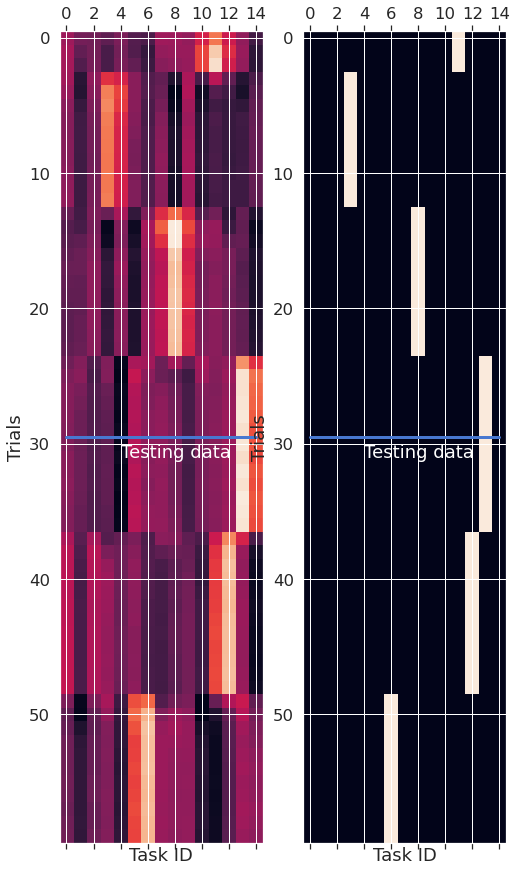

In [84]:
#eval

b_example = 5970
model_preds, model_acts, acc = test_model(model, [b_example], )
print('gru_acts shape : ', model_acts.shape)
fig, axes = plt.subplots(1,2, figsize=[8,16])
ax = axes[0]
ax.matshow(model_preds.reshape([-1, 100, 15]).mean(1))
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')

ax = axes[1]
ax.matshow(task_ids_oh[b_example:b_example+test_input_length])
ax = plt.gca()
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')


# print(task_ids[b_example:b_example+test_input_length])
# plt.savefig('Cognitive_observer_preds.jpg', dpi=300)

16.0


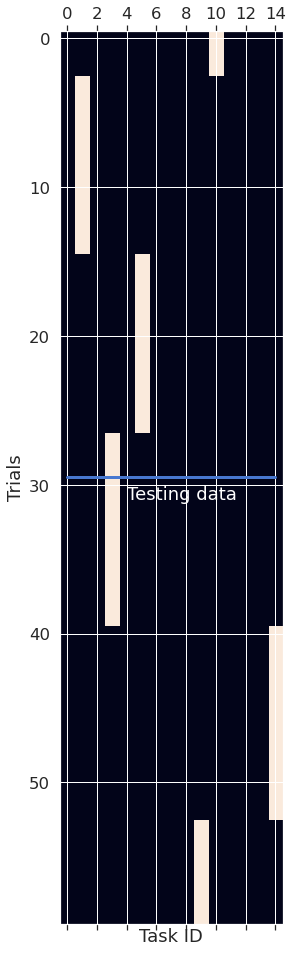

In [71]:
plt.matshow(task_ids_oh[b_example:b_example+test_input_length])
ax = plt.gca()
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')

print(plt.gcf().get_figheight())
# plt.savefig('Cognitive_observer_gt.jpg', dpi=300)

shape of contactanted gru preds:  (2880, 15)


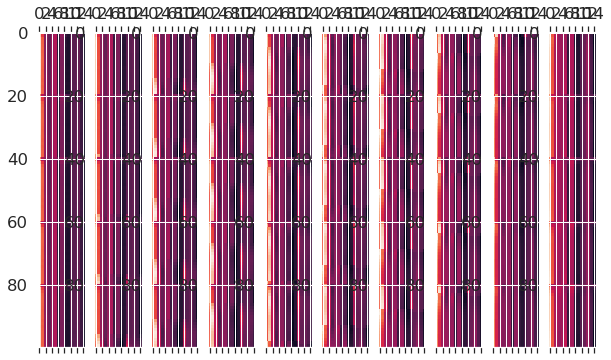

In [28]:
fig, axes = plt.subplots(1,10, figsize=[10,10])
gc = np.concatenate(gru_preds, axis =0).mean(1)
print('shape of contactanted gru preds: ', gc.shape)
for i in range(10):
    axes[i].matshow(gc[1000+(i*100):1000+(i*100)+100])

In [15]:
(task_ids[1000:1000+input_length])

array([4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6])

shae:  (2880, 15)


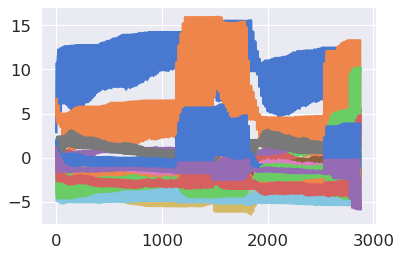

In [ ]:
print('shae: ', (gru_preds.reshape([-1, 100, 15]).mean(1)).shape)
plt.plot(gru_preds.reshape([-1, 100, 15]).mean(1))

In [ ]:
if False: # this is compabilbe only of labels anouptputs are not np.stacked
    fig, axes = plt.subplots(1,3, figsize=[6,6])
    trial_no = 5 #
    batch_no = 81 # in batch 601: 10 13 18 are false in all of them, it is too much noise!
    task_no = 9
    axes[0].matshow(inputs [task_no][batch_no][:,trial_no,:].T)
    axes[1].matshow(labels [task_no][batch_no][trial_no,:, np.newaxis])
    axes[2].matshow(outputs[task_no][batch_no][trial_no,:, np.newaxis])
    correct = np.argmax(outputs[task_no][batch_no][trial_no,:], axis =-1) == np.argmax(labels[task_no][batch_no][trial_no,:], axis =-1)
    print ('correct: ', correct)

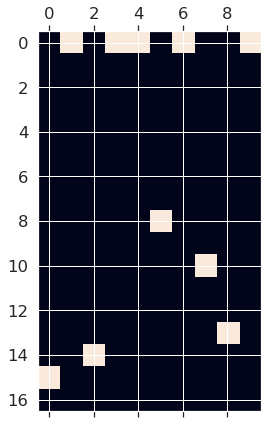

In [ ]:
plt.matshow(labels[700, :10,: ].T)

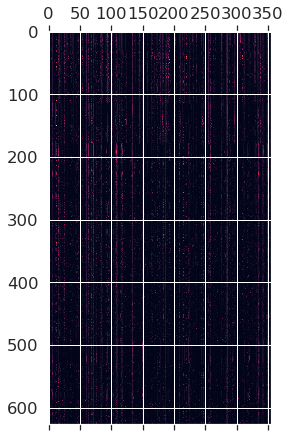

In [ ]:
plt.matshow(acts.reshape([-1, 356])[0:-1:500])

In [ ]:
print(change_trials)

In [ ]:
# create the task class vector
N = acts.reshape([-1, 256]).shape[0]
ct = [0]+change_trials
ct = [int(c*100) for c in ct]
task_class = np.zeros((N,1))
for i in range(num_tasks):
    task_class[ct[i]:ct[i+1]] = i
plt.plot(task_class)    

In [ ]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

In [ ]:
x= X_emb 

colors = task_class[0:-1:sampling_rate]
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


acc shape:  (3127, 100)
previous reward shape:  (3127, 100)


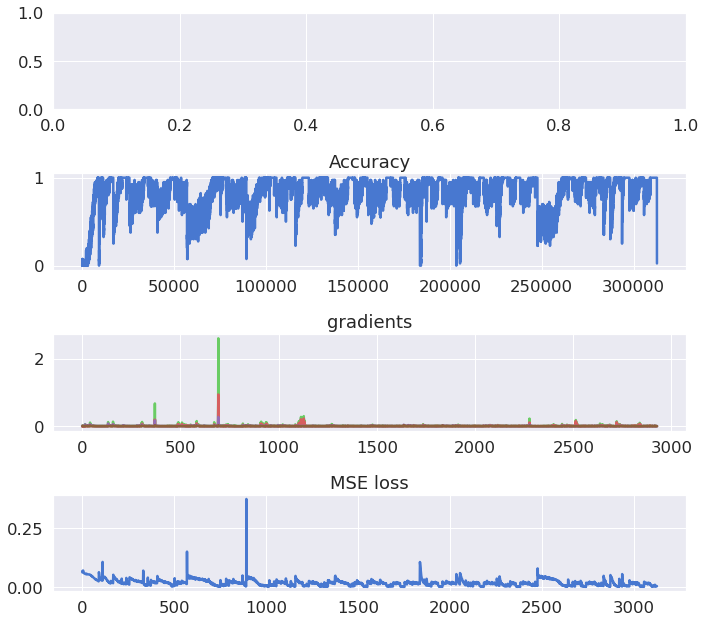

In [ ]:
rl = np.argmax(labels, axis=-1)
ro = np.argmax(outputs, axis=-1)
mses= ((labels-outputs)**2).mean(-1) # shape (7800, 100)

acc = (rl==ro).astype(np.float32)
print('acc shape: ', acc.shape)
fig, axes = plt.subplots(4,1, figsize=[10,9])
# axes[0].scatter(range(61000), acc.reshape([-1])[:61000]) #.mean(1))
# axes[0].plot(np.convolve( np.ones(40)/40, acc.reshape([-1])[:61000])) #.mean(1))
axes[1].plot(np.convolve( np.ones(40)/40, acc.reshape([-1]))) #.mean(1))
axes[1].set_title('Accuracy')
axes[2].plot(gradients[200:])
axes[2].set_title('gradients')
axes[3].plot(mses.mean(1))
axes[3].set_title('MSE loss')
previous_acc = np.concatenate([mses[:1], mses ])[:-1] #shift by one place to make it run one step behind. 
print('previous reward shape: ', previous_reward.shape)
plt.tight_layout()


### Start preparing for trainingz

In [ ]:
print('output shapes: ', acc.shape)
print('input shape: ' , acts.shape)

In [ ]:
expanded_previous_reward = np.repeat(previous_reward[..., np.newaxis], 10, axis=-1)
inpu = np.concatenate([acts, expanded_previous_reward], axis=-1) #shape  7100 100 266
input_length = 500
training_cycles = 200


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        # inp = self.bn(inp)
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

In [ ]:
rng = np.random.default_rng()

use_inputs = expanded_previous_reward
model = Net(input_size=use_inputs.shape[-1], hidden_size=258, output_size=1)
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss(reduction='mean')
losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = np.random.randint(0, acts.shape[0]- input_length)
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(use_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(acc[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(outs, pred.squeeze() )
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)


In [ ]:
# Shapes cell:
print('shape of expanded_previous_rewaqrd: ', expanded_previous_reward.shape)


In [ ]:
rng = np.random.default_rng()

use_inputs = expanded_previous_acc
model = Net(input_size=use_inputs.shape[-1], hidden_size=258, output_size=1)
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss(reduction='mean')
losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = np.random.randint(0, acts.shape[0]- input_length)
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(use_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(acc[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(outs, pred.squeeze() )
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)



Now gather all acts[-1, 256] and somehow run them through the GRU but in eval mode. Get all the GRU activations, sample them at the same rate and with the same code and do the tsne.

### testing getting complicated

In [ ]:
#eval
model.eval()
gru_acts= []
gru_preds= []
with torch.no_grad():
    for b in trange (use_inputs.shape[0]//input_length):
        eins= torch.tensor(use_inputs[b:b+input_length])
        gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
    #     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        gru_acts.append(gacts.detach().cpu().numpy())
        gru_preds.append(gpreds.detach().cpu().numpy())
model.train()

gru_preds = np.stack(gru_preds)
gru_acts = np.stack(gru_acts)
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
plt.plot(gru_preds.reshape([-1, 100, 1]).mean(1))

In [ ]:
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
plt.plot(gru_preds.reshape([-1, 100, 1]).mean(1))

In [ ]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = gru_acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

In [ ]:
x= X_emb 

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


In [ ]:
def extract_accuracies(logs):
    train = []
    test = []
    num_tasks = len(logs)
    for logi in range(num_tasks):
        for task_i in range(num_tasks):
            log = logs[logi]
            if logi== task_i:
                train.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    #                 log['accuracy']task_i])
            else:
                test.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    return(np.stack(train), np.stack(test))


def extract_accuracies_all(logs):
    train = []

    num_tasks = len(logs)
    for logi in range(num_tasks):
        task_tests = []
        for task_i in range(num_tasks):
            log = logs[logi]
            task_tests.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
        train.append(task_tests)
    return(np.stack(train))


# def get_np_acc(logs, num_tasks):
#     logs_tasks_tests_acc = []
#     for logi in range(len(logs)):
#         test_accuracies = []
#         for task_i in range(num_tasks):
#             test_accuracies.append([t[task_i] for t in logs[logi]['accuracy']])
#         logs_tasks_tests_acc.append(np.stack(test_accuracies))

#     ltta = np.stack(logs_tasks_tests_acc)
#     return(ltta)


# tr_acc = get_np_acc(train, 15)
# te_acc = get_np_acc(test, 15)

In [ ]:
# two figs 
plt.close('all')
logs = testing_logs1
num_tasks = len(logs)
title_label = 'Training tasks sequentially ---> \n    ' #+ config['exp_name']
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs1[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, label=label1)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5, label=label1)
        if True:
            log = testing_logs2[logi]
            ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, color='tab:orange', label=label2)

        if li == 0: ax.set_title(config['human_task_names'][logi])
            
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[1, num_tasks-1].legend()

for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        log = testing_logs2[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)

        
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
      mul_gate: {"True" if config["use_gates"] else "False"}\
          {exp_signature}'
axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig(f'./files/{label1}_vs_{label2}.png', dpi=300)

In [ ]:
tr1, te1 = extract_accuracies(testing_logs1)
tr2, te2 = extract_accuracies(testing_logs2)


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
ax = axes[0,0]
ax.set_title('trained task')
ax.plot(testing_logs1[0]['stamps'], tr1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], tr2.mean(axis=(0)), color='red', label=label2)
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('performance')
ax.set_xlabel('batch #')
ax.legend()

ax = axes[0,1]
ax.set_title('other tasks')
ax.plot(testing_logs1[0]['stamps'], te1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], te2.mean(axis=(0)), color= 'red', label=label2)
ax.set_xlabel('batch #')
ax.legend()

ax.set_ylim([-0.1, 1.1])
# fig.savefig('./files/gates_no_gates_comp.jpg')
fig.savefig(f'./files/{label1}_{label2}comp.png', dpi=600)

logs[0]['accuracy'] has 20 enteries for each time step, and each entry has accuracy of all tasks at that time step.

In [ ]:
tt = extract_accuracies_all(logs)

In [ ]:
def get_diffs(logs, triangle='upper', k=1):
    '''take a log, and return the improvement in the mean accuracy of tasks
    triangle: look at "upper" or "lower" triangle corrospondin to "after" or "before" index task was trained
    k: take from diagonal (0) or above it (1) or below it (-1)'''
    
    tt = extract_accuracies_all(logs)
    tavg = tt.mean(-1)

    tdiff = tavg[1:, :] -  tavg[:-1, :]    
    if triangle == 'upper':
        tri = tdiff[np.triu_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
    elif (triangle == 'lower'):
        tri = tdiff[np.tril_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri    
    
    sorted_diffs = np.sort(tri)
    return(sorted_diffs)


comp1 = get_diffs(testing_logs1, 'upper', 1)
comp2 = get_diffs(testing_logs2, 'upper', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('upper')


In [ ]:
comp1 = get_diffs(testing_logs1, 'lower', 1)
comp2 = get_diffs(testing_logs2, 'lower', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('lower')


In [ ]:
comp1.mean()

In [ ]:
comp2.mean()

In [ ]:
tavg = tt.mean(-1)

In [ ]:
tavg

In [ ]:
tdiff = tavg[1:, :] -  tavg[:-1, :]

In [ ]:
tdiff.shape

In [ ]:
np.triu(tdiff,1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
np.tril(tdiff,-1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
ut = tdiff[np.triu_indices_from(tdiff,1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
lt = tdiff[np.tril_indices_from(tdiff,-1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri

In [ ]:
tdiff[np.tril_indices_from(tdiff,-1)]

In [ ]:
tdiff.shape

In [ ]:
plt.bar(range(ut.shape[0]), np.sort(ut))
plt.bar(range(lt.shape[0]), np.sort(lt))


In [ ]:
help(np.sort)

In [ ]:
te1.shape

In [ ]:
with_gates_te = te_acc
with_gates_tr = tr_acc

In [ ]:

fig, ax = plt.subplots(1)
logs = testing_logs

train = []
test = []
for logi in range(num_tasks):
    for li in range(num_tasks):
        log = testing_logs[logi]
        if logi== li:
            train.append(logs[logi]['accuracy'])
        else:
            test.append(logs[logi]['accuracy'])

    
            
train = np.stack(train)
test = np.stack(test)
print(train.shape)
print(test.shape)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0, max_x])
ax.plot(log['stamps'], train.mean(axis=0), linewidth=2)
ax.plot(log['stamps'], test.mean(axis=0), color='grey', linewidth=2)
# if li == 0: ax.set_title(config['human_task_names'][logi])
# if logi == 0: ax.set_ylabel(config['human_task_names'][li])
ax.set_yticklabels([]) 
ax.set_xticklabels([])
        
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
    ax.set_xlabel('batch #')


In [ ]:
np.stack(train[0][0].values())

In [ ]:
logs[0]['accuracy']

In [ ]:
test_accuracies = []
for task_i in range(15):
    test_accuracies.append([test[task_i] for test in logs[0]['accuracy']])


In [ ]:
ta = np.stack(test_accuracies)

In [ ]:

ta.shape

In [ ]:
ta

In [ ]:
task_i = 0
zz= zip(log['stamps'], [test[task_i] for test in logs[0]['accuracy']])

In [ ]:
[print( (z, a)) for z, a in zz]